# But : Créer un masque des bâtiments avec l'image infrarouge Pléiade.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
! pip install rasterio  -q -q -q
! pip install geopandas -q -q -q
! pip install matplotlib -q -q -q

In [3]:
!pip install pyarrow
!pip install opencv-python
!pip install os-sys

  Using cached os_sys-2.1.4-py3-none-any.whl (15.6 MB)
  Using cached cefpython3-66.0-py2.py3-none-manylinux1_x86_64.whl (79.6 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 4.1 MB/s eta 0:00:00
  Using cached spacy-2.2.0.tar.gz (5.8 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [49 lines of output]
      Traceback (most recent call last):
        File "/tmp/pip-build-env-6on3vu8_/overlay/lib/python3.10/site-packages/setuptools/_vendor/packaging/requirements.py", line 35, in __init__
          parsed = parse_requirement(requirement_string)
        File "/tmp/pip-build-env-6on3vu8_/overlay/lib/python3.10/site-packages/setuptools/_vendor/packaging/_parser.py", line 64, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
        File "/tmp/pip-build-env-6

In [4]:
import sys
sys.path.append('../src')
from satellite_image import SatelliteImage
from utils import *

lancer ca dans le terminal avant d'importer cv2 :
sudo apt-get update
sudo apt-get install ffmpeg libsm6 libxext6 -y
sudo apt-get install libgl1

In [6]:
import yaml
import re
import s3fs
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image as im

In [7]:
update_storage_access()

In [8]:
environment = get_environment()

root_path = get_root_path()
bucket = environment["bucket"]
path_s3_cayenne_data = environment["sources"]["PLEIADES"]
path_local_cayenne_data = os.path.join(root_path, environment["local-path"]["PLEIADES"])
bucket = environment["bucket"]

path_s3_pleiades_data = environment["sources"]["PLEIADES"]
path_s3_bdtopo_data = environment["sources"]["BDTOPO"][2022]["guyane"]
path_local_pleiades_data = environment["local-path"]["PLEIADES"]
path_local_bdtopo_data = environment["local-path"]["BDTOPO"][2022]["guyane"]


fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

In [9]:
# DL PLEIADE
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data}",
        lpath=f"../{path_local_pleiades_data}",
        recursive=True)

In [10]:
# DL BDTOPO
fs.download(
        rpath=f"{bucket}/{path_s3_bdtopo_data}",
        lpath=f"../{path_local_bdtopo_data}",
        recursive=True)

## Chargement données pléiades.

In [11]:
filename = '../data/PLEIADES/Cayenne/16bits/ORT_2022072050325085_U22N/ORT_2022072050325085_0353_0545_U22N_16Bits.jp2'
date = datetime.strptime(re.search(r'ORT_(\d{8})', filename).group(1), '%Y%m%d')
date

datetime.datetime(2022, 7, 20, 0, 0)

In [12]:
image = SatelliteImage.from_raster(
        filename,
        date = date, 
        n_bands = 4,
        dep = "973"
    )
image.normalize()

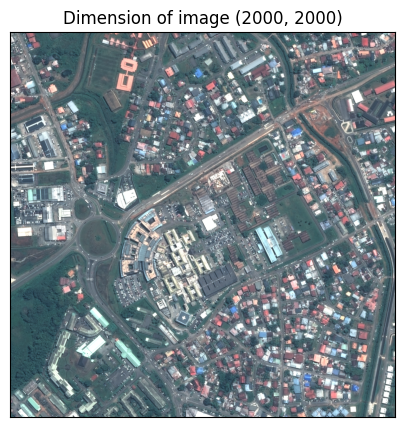

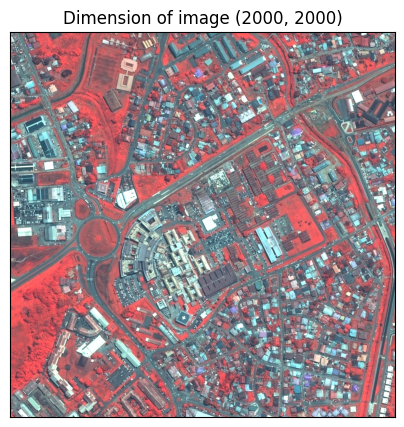

In [13]:
image.plot([0,1,2])
image.plot([3,1,2])

## D'abord : un masque binaire avec en blanc les bâtiments et les routes.
Pour commencer ceci, on veut avoir l'image avec la bande infrarouge en format png pour pouvoir utiliser le package OpenCv.

In [14]:
#On va d'abord récuperer l'array avec la bande infrarouge 
#faire un array sans la couleur rouge pour l'image en 51e position de la liste d'images
if not image.normalized:
    image.normalize() 
img = image.array

#avoir la bande infrarouge
img = img[[3,1,2],:, :]

#multiplication par 255 et convertion en uint8 pour avoir le bon format
img = (img * 255).astype(np.uint8)

#convertir l'array en image PIL pour ensuite l'avoir en png
img = im.fromarray(img.transpose(1, 2, 0).astype('uint8'), 'RGB')

#enregistrer l'image en tant que fichier PNG pour pouvoir utiliser OpenCV
img.save('im50.png')

Afin de ne pas faire crasher le kernel, nous allons préalablement créer des fonctions d'affichage des images avec OpenCV (la fonction de base cv2.imshow() fait crasher le kernel)

In [15]:
#images en nuances de gris
def cv2_imshow(a, **kwargs):
    a = a.clip(0, 255).astype('uint8')
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_RGBA2BGRA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_RGB2BGR)

    return plt.imshow(a, **kwargs, cmap= "gray")

#images en couleurs
def cv2_imshow2(a, **kwargs):
    a = a.clip(0, 255).astype('uint8')
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_RGBA2BGRA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_RGB2BGR)

    return plt.imshow(a, **kwargs, cmap= "brg")


In [16]:
#on lit l'image avec OpenCV
img = cv2.imread('im50.png', cv2.IMREAD_COLOR)

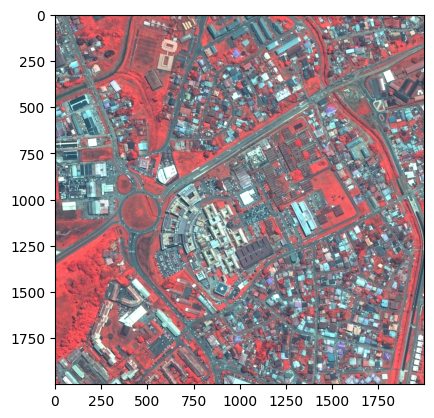

In [17]:
cv2_imshow2(img)

## Idée globale : si le pixel est rouge, le changer en noir, le reste en blanc.
Pour cela, il faut fixer des seuils : quels nuances de rouges colorier en noir ou en blanc ?
Ici les pixels sont en décimal BGR

*Etape 1 : Pour que le pixel soit une nuance de rouge, il faut d'abord vérifier si les valeurs verte et bleue sont proches.
*Etape 2 : On décide que les nuances de rouge très claires correspondent à des toits de bâtiments.
*Etape 3 : On fixe le seuil de la valeur rouge à 110 et la valeur de rouge avec une autre couleur doit être supérieure à 20 minimum.
*Etape 4 : Si le pixel ne vérifie aucune des étapes précédentes, alors il est colorié automatiquement en blanc.

In [18]:
# On va parcourir tous les pixels de l'image
for row in range(img.shape[0]):
    for col in range(img.shape[1]):
        mini = min(img[row, col, 0],img[row, col, 1])
        
        if -20 <= (img[row, col, 0] - img[row, col, 1]) <= 20 : #étape 1
            
            if img[row, col, 2] > 230 and mini >= 140 : #étape 2
                img[row, col] = [255, 255, 255] # blanc
            elif  (img[row, col, 2] - mini)>= 20 and img[row, col, 2] >= 110: #étape 3
            else : #étape 4
                img[row, col] = [255, 255, 255] # blanc

        else : #étape 4
            img[row, col] = [255, 255, 255] # blanc

/tmp/ipykernel_847/1704092571.py:12: RuntimeWarning: overflow encountered in ubyte_scalars
  elif  (img[row, col, 2] - mini)>= 20 and img[row, col, 2] >= 110: #on fixe le seuil de la valeur rouge à 120 et la valeur de rouge avec une autre couleur doit être supérieure à 20 minimum
/tmp/ipykernel_847/1704092571.py:8: RuntimeWarning: overflow encountered in ubyte_scalars
  if -20 <= (img[row, col, 0] - img[row, col, 1]) <= 20 : #pour que le pixel soit une nuance de rouge, il faut d'abord vérifier si les valeurs verte et bleue sont proches


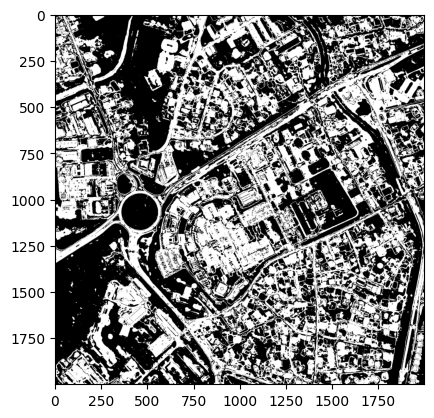

In [19]:
cv2_imshow2(img)